In [1]:
import os
import time
import gzip
import pickle
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric

#Device Setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on {'GPU' if device.type == 'cuda' else 'CPU'}")

#Model Construction
class GCNPair(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1_l = GCNConv(input_dim, hidden_dim, aggr='add').to(device)
        self.conv2_l = GCNConv(hidden_dim, hidden_dim, aggr='add').to(device)
        self.conv1_r = GCNConv(input_dim, hidden_dim, aggr='add').to(device)
        self.conv2_r = GCNConv(hidden_dim, hidden_dim, aggr='add').to(device)
        self.fc1 = torch.nn.Linear(hidden_dim * 2, hidden_dim).to(device)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim).to(device)

    def forward(self, graph_l, graph_r, labels):
        x_l = self.conv1_l(graph_l.x, graph_l.edge_index).relu()
        x_l = F.dropout(x_l, p=0.6, training=self.training)
        x_l = self.conv2_l(x_l, graph_l.edge_index)

        x_r = self.conv1_r(graph_r.x, graph_r.edge_index).relu()
        x_r = F.dropout(x_r, p=0.6, training=self.training)
        x_r = self.conv2_r(x_r, graph_r.edge_index)

        #Merging and MLP, see below
        x_merge = merge_graphs(x_l, x_r, labels)
        x = F.relu(self.fc1(x_merge))
        #x = F.dropout(x, p=0.3, training=self.training)
        out = self.fc2(x)
        return out

#Some important functions
def merge_graphs(x_l, x_r, labels):
    merged_features = []
    for label in labels:
        l_index, r_index, _ = label
        l_features = x_l[l_index]
        r_features = x_r[r_index]
        merged_feature = torch.cat((l_features, r_features), dim=0)
        merged_features.append(merged_feature)
    merged_features = torch.stack(merged_features).to(device)
    return merged_features

def map_labels(label):
    return (label + 1) // 2

def load_cpkl_gz(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

def load_data(folder, pair_id, data):
    #Load graph data objects
    with open(f'./constructed_graphs/{folder}/protein_pair_{pair_id}_l.pkl', 'rb') as f:
        graph_l = pickle.load(f).to(device)
    with open(f'./constructed_graphs/{folder}/protein_pair_{pair_id}_r.pkl', 'rb') as f:
        graph_r = pickle.load(f).to(device)
    label = data[1][pair_id]['label']
    return graph_l, graph_r, label

# Train and Test functions
def train_one_epoch(model, optimizer, criterion, train_data, epoch):
    total_loss = 0
    correct = 0
    total = 0
    model.train()
    for pair_id in range(len(train_data[1])):
        graph_l, graph_r, label = load_data('train', pair_id, train_data)
        label_mapped = map_labels(label[:,-1])#CE loss expectes 0/1 labels for y
        label_tensor = torch.tensor(label_mapped, dtype=torch.long).to(device)
        #Up till now labels are ok
        optimizer.zero_grad()
        out = model(graph_l, graph_r, label)
        loss = criterion(out, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == label_tensor).sum().item()
        total += label_tensor.size(0)
    avg_loss = total_loss / len(train_data[1])
    train_acc = correct / total
    print(f'Epoch: {epoch:03d}, Loss: {avg_loss:.5f}, Accuracy: {train_acc:.5f}')
    return avg_loss, train_acc

def test(model, criterion, test_data):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    correct = 0
    total = 0

    with torch.no_grad():
        for pair_id in range(len(test_data[1])):
            graph_l, graph_r, label = load_data('test', pair_id, test_data)
            label_mapped = map_labels(label[:,-1])
            label_tensor = torch.tensor(label_mapped, dtype=torch.long).to(device)

            out = model(graph_l, graph_r, label)
            pred = out.argmax(dim=1)
            prob = F.softmax(out, dim=1)[:, 1] 

            y_true.extend(label_tensor.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_scores.extend(prob.cpu().numpy())

            correct += (pred == label_tensor).sum().item()
            total += label_tensor.size(0)

    test_acc = correct / total
    return test_acc, y_true, y_pred, y_scores


# Load data
train_data = load_cpkl_gz('./dataset/train.cpkl.gz')
test_data = load_cpkl_gz('./dataset/test.cpkl.gz')

# Initialize the model, optimizer, and loss function
model = GCNPair(input_dim=70, hidden_dim=32, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#Neg sample: Pos sample == many:few, so we need to assign weight to CE loss
#This step is really really important!!!!!!!!!!
weight = torch.tensor([1, 6], dtype=torch.float32).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weight)

# Training and Testing
start_time = time.time()
train_losses, train_accuracies = [], []
for epoch in range(1, 41):
    train_loss, train_accuracy = train_one_epoch(model, optimizer, criterion, train_data, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
end_training_time = time.time()

test_accuracy,y_true, y_pred, y_scores= test(model, criterion, test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')
end_testing_time = time.time()

print(f"Training took {end_training_time - start_time:.2f} seconds.")
print(f"Inference took {end_testing_time - end_training_time:.2f} seconds.")

Running on GPU
Epoch: 001, Loss: 0.65595, Accuracy: 0.86750
Epoch: 002, Loss: 0.64511, Accuracy: 0.85771
Epoch: 003, Loss: 0.63165, Accuracy: 0.84631
Epoch: 004, Loss: 0.62405, Accuracy: 0.85474
Epoch: 005, Loss: 0.62906, Accuracy: 0.85372
Epoch: 006, Loss: 0.61291, Accuracy: 0.84359
Epoch: 007, Loss: 0.60893, Accuracy: 0.83793
Epoch: 008, Loss: 0.61171, Accuracy: 0.83195
Epoch: 009, Loss: 0.61718, Accuracy: 0.84625
Epoch: 010, Loss: 0.61579, Accuracy: 0.83509
Epoch: 011, Loss: 0.60398, Accuracy: 0.82891
Epoch: 012, Loss: 0.60057, Accuracy: 0.82324
Epoch: 013, Loss: 0.59362, Accuracy: 0.82908
Epoch: 014, Loss: 0.59540, Accuracy: 0.83152
Epoch: 015, Loss: 0.59107, Accuracy: 0.81801
Epoch: 016, Loss: 0.58821, Accuracy: 0.82860
Epoch: 017, Loss: 0.58969, Accuracy: 0.81993
Epoch: 018, Loss: 0.58548, Accuracy: 0.81970
Epoch: 019, Loss: 0.58330, Accuracy: 0.82568
Epoch: 020, Loss: 0.58046, Accuracy: 0.82352
Epoch: 021, Loss: 0.57742, Accuracy: 0.81495
Epoch: 022, Loss: 0.58054, Accuracy: 0.8

# Saving and Loading

In [8]:
#torch.save(model.state_dict(), './models/40epoch_CEweight6_GCN_node_model.pth')

#How to load model and use it for inference
#model = YourModelClass(input_dim, hidden_dim, output_dim) #create a new model object
#model.load_state_dict(torch.load('model.pth')) #parameter loading
#model.eval()  #evaluation mode

# Several Evaluation

In [4]:
def predict_on_selected_samples(model, test_data, selected_samples):
    model.eval()
    predictions = []
    for pair_id in selected_samples:
        graph_l, graph_r, label = load_data('test', pair_id, test_data)
        label_mapped = map_labels(label[:,-1])
        label_tensor = torch.tensor(label_mapped, dtype=torch.long).to(device)
        out = model(graph_l, graph_r, label)
        pred = out.argmax(dim=1)
        predictions.append(pred)
    return predictions
    
# Select observations from the test set
selected_samples = [0]

predictions = predict_on_selected_samples(model, test_data, selected_samples)
pred=predictions[0].tolist()
print(pred[:20])
# num of 0 and 1
count_1 = pred.count(1);count_0 = pred.count(0)
print("Number of 1s:", count_1);print("Number of 0s:", count_0)

#############################################################################

#True label
True_label=test_data[1][0]['label'][:,2].tolist()
True_label = [0 if label == -1 else label for label in True_label]
print(len(True_label))
# num of 0 and 1
count_1 = True_label.count(1);count_0 = True_label.count(0)
print("Number of 1s:", count_1);print("Number of 0s:", count_0)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of 1s: 1091
Number of 0s: 220004
221095
Number of 1s: 89
Number of 0s: 221006


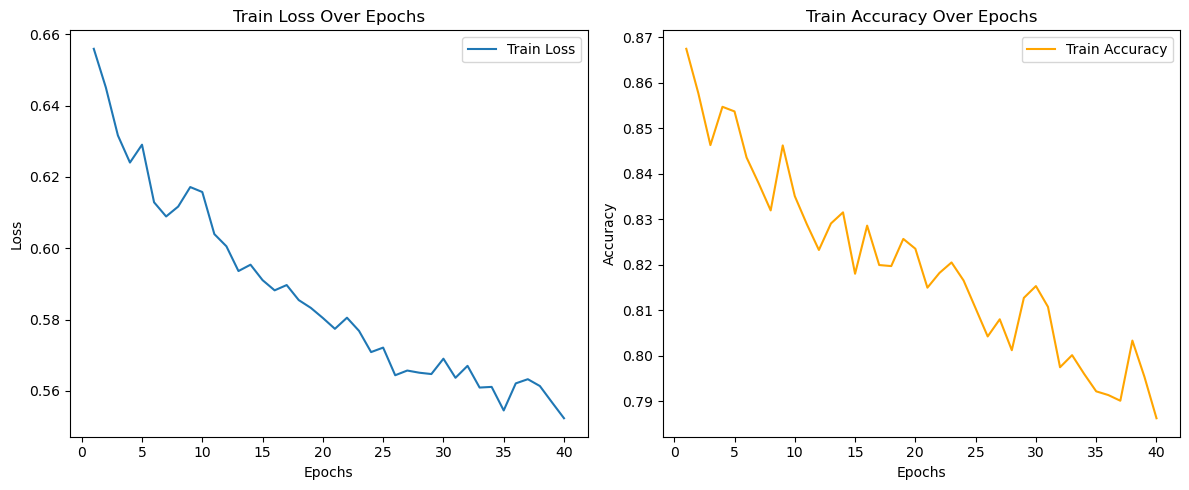

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, 41)
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


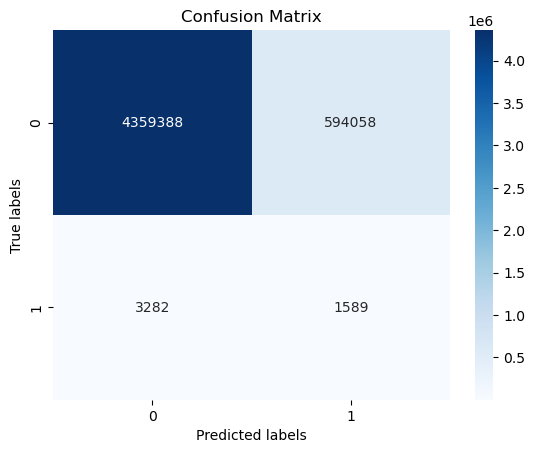

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


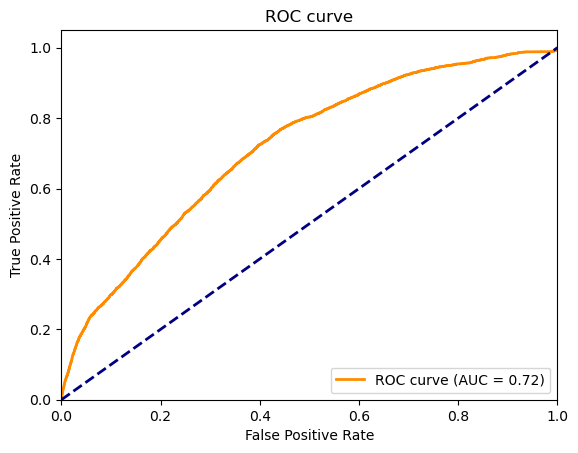

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()